In [1]:
import sys
import os

root_path = os.path.abspath('..')
if root_path not in sys.path:
    sys.path.insert(0, root_path)
    
functions_path = os.path.abspath('../Functions')
data_path = os.path.abspath('../Data')
algorithms_path = os.path.abspath('../Algorithms')

sys.path.append(functions_path)
sys.path.append(data_path)
sys.path.append(algorithms_path)

import numpy as np
import pandas as pd
import ruptures as rpt
import matplotlib.pyplot as plt
import time
import stumpy
from stumpy.floss import _rea
from Functions.metrics import f_measure, covering
# from Functions.evaluate_floss import evaluate_floss
# from Algorithms.floss import floss

In [2]:
def floss(ts, sliding_window_size, window_size, n_cps, return_cac=False):
    mp = stumpy.stump(ts[:sliding_window_size], m=window_size)

    stream = stumpy.floss(
        mp,
        ts[:sliding_window_size],
        m=window_size,
        L=window_size
    )

    cac = np.full(ts.shape[0], fill_value=np.inf, dtype=np.float64)

    for dx, timepoint in zip(range(sliding_window_size, ts.shape[0]), ts[sliding_window_size:]):
        stream.update(timepoint)
        window_cac = stream.cac_1d_

        cac[max(0, dx - window_cac.shape[0]+1):dx+1] = np.min([
            cac[max(0, dx - window_cac.shape[0]+1):dx+1],
            window_cac[max(0, window_cac.shape[0]-dx-1):]
        ], axis=0)

    cps = _rea(cac, L=window_size, n_regimes=n_cps+1)

    if return_cac is True:
        return cac, cps

    return cps


In [3]:
def evaluate_floss(dataset, routine, subject, sensor, sample_rate, cps, activities, ts, **seg_kwargs):
    profile, found_cps = floss(ts, 20*sample_rate, sample_rate, n_cps=len(cps), return_cac=True, **seg_kwargs)

    f1_score1, percision, recall = f_measure({0: cps}, found_cps, margin=int(ts.shape[0] * .01), return_PR=True)
    f1_score = 2 * (percision * recall) / (percision + recall)
    covering_score = covering({0: cps}, found_cps, ts.shape[0])

    # print(f"{dataset}: F1-Score: {np.round(f1_score, 3)}, Covering-Score: {np.round(covering_score, 3)}")
    return dataset, cps, found_cps, np.round(f1_score, 3), np.round(covering_score, 3), profile, percision, recall

In [4]:
def process_plot_evaluate_pid_floss(pid_df, pid, window_size, routine, subject, sensor):
    ts = pid_df["RWrist_Y"].to_numpy()
    sample_rate = ts.shape[0] // 100
    frame_peaks = pid_df["frame_peaks"].to_numpy()
    true_change_points = [i for i, peak in enumerate(frame_peaks) if peak == 1]

    start_time = time.time()
    n_cps = len(true_change_points)
    detected_cps = floss(ts, 20*sample_rate, window_size, n_cps=n_cps, return_cac=False)
    end_time = time.time()
    elapsed_time = end_time - start_time

    # dataset, true_cps, detected_cps, f1_score, covering_score, _ = evaluate_floss(pid, routine, subject, sensor, sample_rate, true_change_points, [], ts)
    _, _, detected_cps, f1_score, covering_score, _, percision, recall = evaluate_floss(pid, routine, subject, sensor, sample_rate, true_change_points, [], ts)

    if 1 == 0:
        plt.figure(figsize=(15, 6))
        plt.plot(ts, label=f'Time Series Data for {pid}')
        for cp in detected_cps:
            plt.axvline(x=cp, color='red', linestyle='--', linewidth=1, label='Detected Change Point' if cp == detected_cps[0] else "")
        for cp in true_change_points:
            plt.axvline(x=cp, color='green', linestyle='-', linewidth=1, label='True Change Point' if cp == true_change_points[0] else "")
        plt.xlabel('Time')
        plt.ylabel('RWrist_Y Value')
        plt.title(f'PID {pid} - Time: {elapsed_time:.4f}s, F1: {f1_score:.6f}, Cover: {covering_score:.6f}, Precision: {percision:.6f}, Recall: {recall:.6f}')
        plt.legend()
        plt.show()

    return pid, true_change_points, detected_cps, f1_score, covering_score, elapsed_time, percision, recall

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load CSV data
csv_file = '..//Data//Physio//OpenPose-RightWristWithoutSegmentation-full_df.csv'
df = pd.read_csv(csv_file)

# Specify parameters for FLoSS
routine = 'Routine1'
subject = 'Subject1'
sensor = 'Accelerometer'
sample_rate = "Eight"  # Replace this with the actual computation if needed
window_size = 20

total_time = 0
total_covering = 0
total_f1 = 0
total_percision = 0
total_recall = 0
num_pids = 0

f1_scores = []
percision_scores = []
recall_scores = []
execution_times = []
coverages = []

for pid, group in df.groupby("pid"):
    result = process_plot_evaluate_pid_floss(group, pid, window_size, routine, subject, sensor)

    total_time += result[-3]
    total_covering += result[-4]
    total_f1 += result[-5]
    total_percision += result[-2]
    total_recall += result[-1]
    
    num_pids += 1
    execution_times.append(result[-3])
    coverages.append(result[-4])
    f1_scores.append(result[-5])
    percision_scores.append(result[-2])
    recall_scores.append(result[-1])


average_time = total_time / num_pids
average_covering = total_covering / num_pids
average_precision = total_percision / num_pids
average_recall = total_recall / num_pids
average_f1 = 2 * ((average_precision * average_recall) / (average_precision + average_recall))


# Directory for FLoSS results
results_dir = "..//Results//Floss"
os.makedirs(results_dir, exist_ok=True)

# Save the figure
plt.savefig(f"{results_dir}/{sample_rate}_graph.png")

# Append the average metrics to the floss_results.txt file
with open(f"{results_dir}/floss_results.txt", "a") as file:
    file.write(f'{sample_rate}: Average Time: {average_time:.4f}s, Average Coverage: {average_covering:.6f}, Average F1 Score: {average_f1:.6f}\n')

print(f"Graphs and metrics for {sample_rate} saved successfully in {results_dir}.")


Graphs and metrics for Eight saved successfully in ..//Results//Floss.


<Figure size 640x480 with 0 Axes>

In [6]:
for i in range(len(percision_scores)):
    if recall_scores[i] != percision_scores[i]:
        print(f"PID: {i}, Recall: {recall_scores[i]}, Precision: {percision_scores[i]}, F1: {f1_scores[i]}")

PID: 33, Recall: 0.5454545454545454, Precision: 0.5, F1: 0.522
PID: 41, Recall: 0.6363636363636364, Precision: 0.5833333333333334, F1: 0.609
PID: 42, Recall: 0.6363636363636364, Precision: 0.5833333333333334, F1: 0.609
PID: 43, Recall: 0.7272727272727273, Precision: 0.6666666666666666, F1: 0.696
PID: 44, Recall: 0.5454545454545454, Precision: 0.5, F1: 0.522
PID: 45, Recall: 0.6363636363636364, Precision: 0.5833333333333334, F1: 0.609
PID: 46, Recall: 0.5454545454545454, Precision: 0.5, F1: 0.522
PID: 47, Recall: 0.6363636363636364, Precision: 0.5833333333333334, F1: 0.609
PID: 48, Recall: 0.7272727272727273, Precision: 0.6666666666666666, F1: 0.696
PID: 49, Recall: 0.6363636363636364, Precision: 0.5833333333333334, F1: 0.609
PID: 50, Recall: 0.6363636363636364, Precision: 0.5833333333333334, F1: 0.609
PID: 51, Recall: 0.6363636363636364, Precision: 0.5833333333333334, F1: 0.609
PID: 52, Recall: 0.36363636363636365, Precision: 0.3333333333333333, F1: 0.348
PID: 53, Recall: 0.36363636363

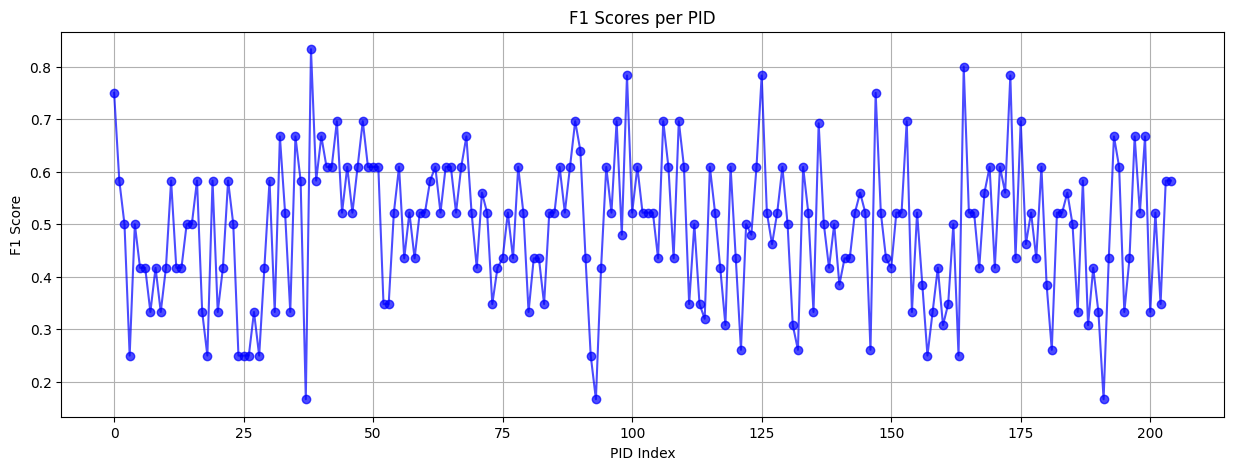

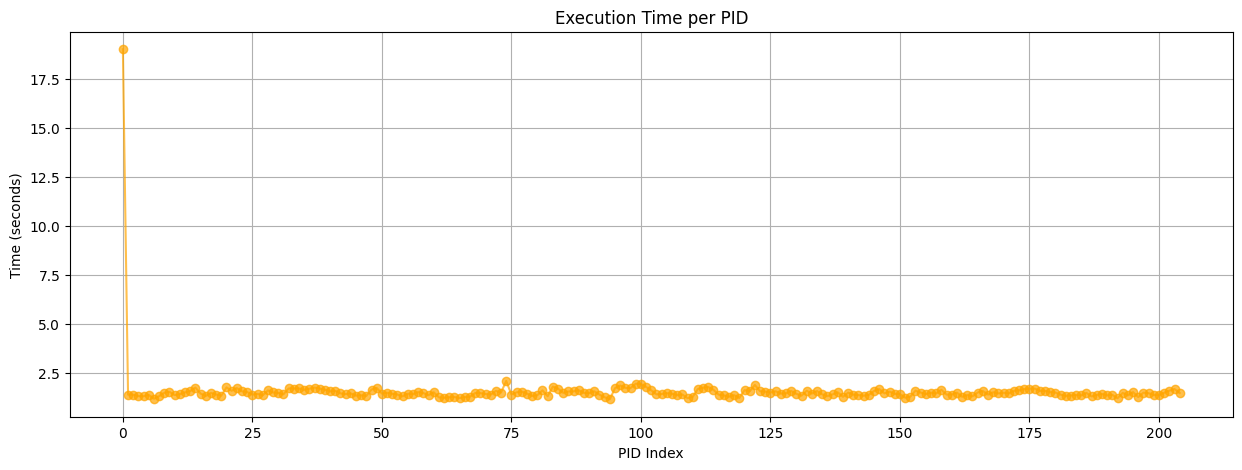

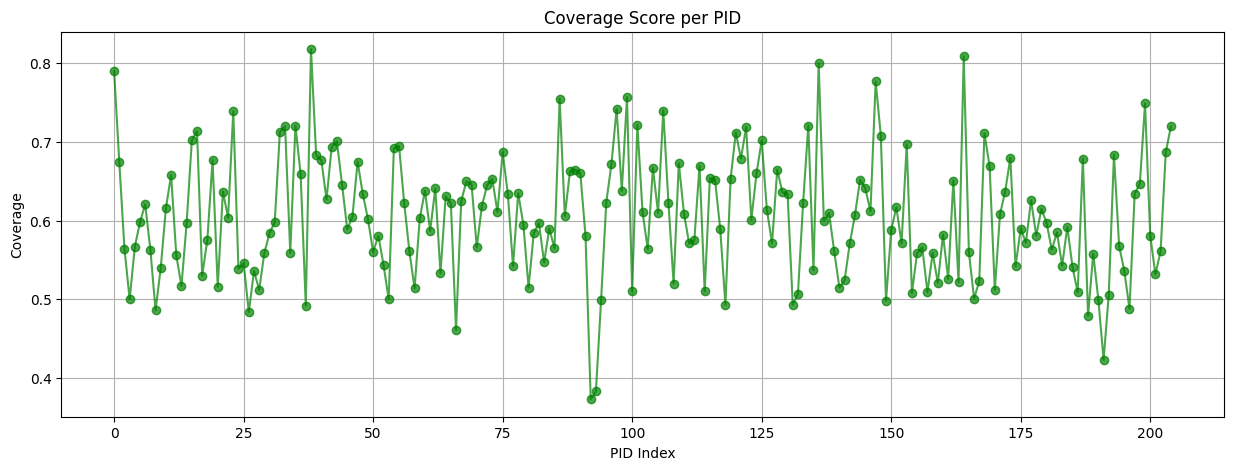

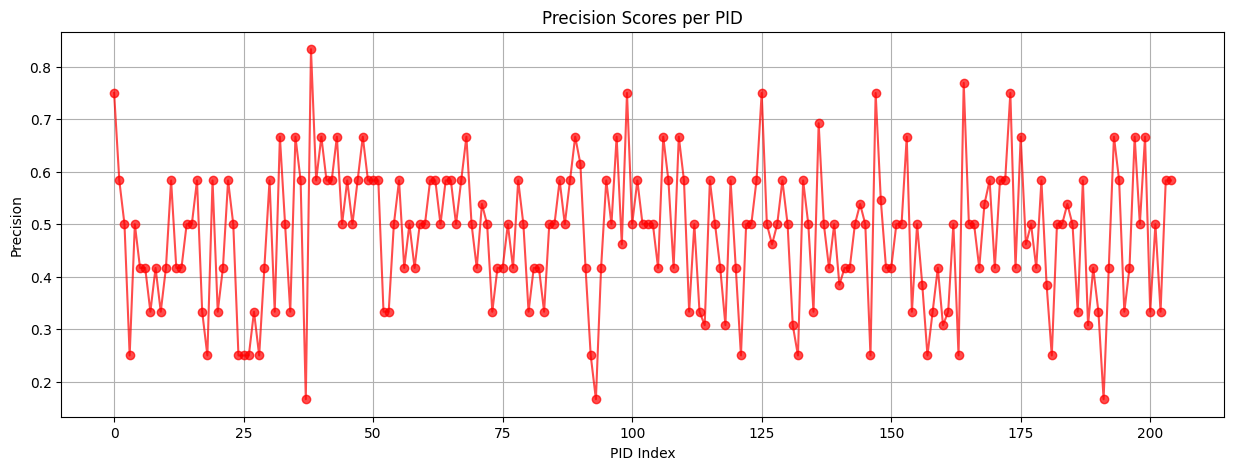

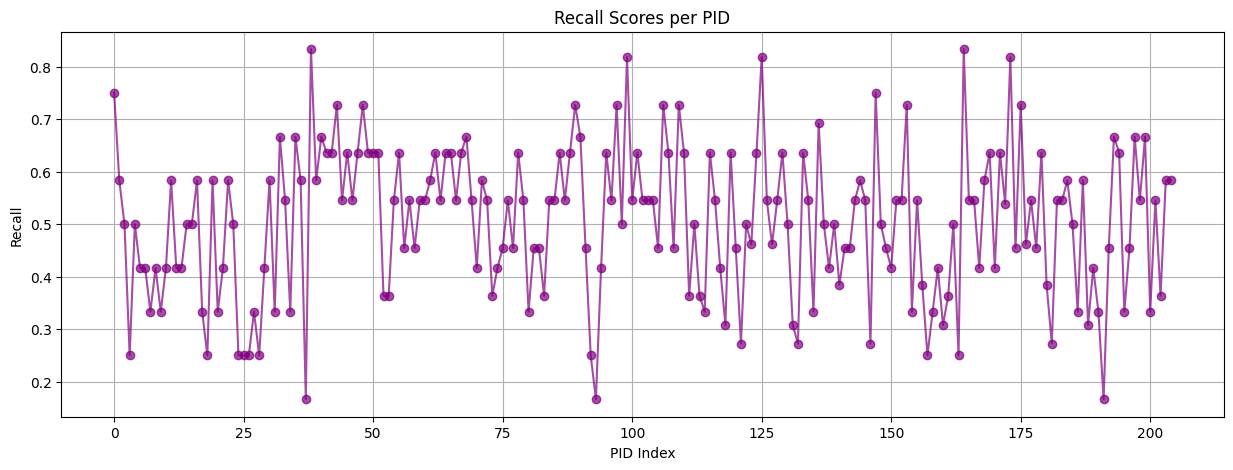

Average Time: 1.5776s, Average Coverage: 0.604688, Average F1 Score: 0.491812, Average Precision: 0.479771, Average Recall: 0.504472


In [7]:
# F1 Scores
plt.figure(figsize=(15, 5))
plt.plot(f1_scores, marker='o', linestyle='-', color='blue', alpha=0.7, label='F1 Score')
plt.title('F1 Scores per PID', fontsize=12)
plt.xlabel('PID Index')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

# Execution Times
plt.figure(figsize=(15, 5))
plt.plot(execution_times, marker='o', linestyle='-', color='orange', alpha=0.7, label='Execution Time')
plt.title('Execution Time per PID', fontsize=12)
plt.xlabel('PID Index')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.show()

# Coverage Scores
plt.figure(figsize=(15, 5))
plt.plot(coverages, marker='o', linestyle='-', color='green', alpha=0.7, label='Coverage')
plt.title('Coverage Score per PID', fontsize=12)
plt.xlabel('PID Index')
plt.ylabel('Coverage')
plt.grid(True)
plt.show()

# Precision Scores
plt.figure(figsize=(15, 5))
plt.plot(percision_scores, marker='o', linestyle='-', color='red', alpha=0.7, label='Precision')
plt.title('Precision Scores per PID', fontsize=12)
plt.xlabel('PID Index')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

# Recall Scores
plt.figure(figsize=(15, 5))
plt.plot(recall_scores, marker='o', linestyle='-', color='purple', alpha=0.7, label='Recall')
plt.title('Recall Scores per PID', fontsize=12)
plt.xlabel('PID Index')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

# Print averages
print(f'Average Time: {average_time:.4f}s, Average Coverage: {average_covering:.6f}, Average F1 Score: {average_f1:.6f}, Average Precision: {average_precision:.6f}, Average Recall: {average_recall:.6f}')